# LIBERTY INSURANCE CASE STUDY

#### By: Santiago Poveda Peñuela

In this notebook we will aim to gradient boosted trees model to predict the amount of claims in the data set. For that first we first make a basic analysis of the data and clean it up. Then I will go throw the necessary steps to cerate the model. 

In [312]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import  seaborn as sb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor , GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error, confusion_matrix
from funciones import InputProcessing, ModelRegTransformer, Combinar_modelos
from sklearn import metrics
import joblib 

I used python 3.8 libraries I use in this are sklearn, seaborn, matplotlib, and category_encoders

In [320]:
!python --version 

Python 3.8.12


In [319]:
!pip freeze

argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
bleach @ file:///tmp/build/80754af9/bleach_1628110601003/work
category-encoders==2.3.0
certifi==2021.10.8
cffi @ file:///C:/ci/cffi_1636542074879/work
colorama @ file:///tmp/build/80754af9/colorama_1607707115595/work
cycler==0.11.0
debugpy @ file:///C:/ci/debugpy_1637073815078/work
decorator @ file:///tmp/build/80754af9/decorator_1632776554403/work
defusedxml @ file:///tmp/build/80754af9/defusedxml_1615228127516/work
entrypoints==0.3
fonttools==4.28.2
importlib-metadata @ file:///C:/ci/importlib-metadata_1631916848487/work
ipykernel @ file:///C:/ci/ipykernel_1633545574250/work/dist/ipykernel-6.4.1-py3-none-any.whl
ipython @ file:///C:/ci/ipython_1635944310712/work
ipython-genutils @ file:///tmp/build/80754af9/ipython_genutils

# Basic data analysis and cleaun-up

We start by reading the csv file and looking at how the data got imported

In [16]:
data = pd.read_csv("casestudy_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   policy_desc                 678013 non-null  int64 
 1   claim_count                 678013 non-null  int64 
 2   cat_areacode                678013 non-null  object
 3   num_vehicleAge              678013 non-null  int64 
 4   num_noClaimDiscountPercent  678013 non-null  int64 
 5   cat_carBrand                678013 non-null  object
 6   num_populationDensitykmsq   678013 non-null  int64 
 7   cat_Region                  678013 non-null  object
 8   ord_vehicleHP               678013 non-null  int64 
 9   num_exposure                678013 non-null  object
 10  cat_fuelType                677991 non-null  object
 11  num_driverAge               677999 non-null  object
dtypes: int64(6), object(6)
memory usage: 62.1+ MB


In [27]:
data.head(10)

,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge
0,1,1,D,0,50,B12,1217,R82,5,0.1,Regular,55
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46
5,13,1,E,2,50,B12,3003,R31,6,0.52,Regular,38
6,15,1,E,2,50,B12,3003,R31,6,0.45,Regular,38
7,17,1,C,0,68,B12,137,R91,7,0.27,Diesel,33
8,18,1,C,0,68,B12,137,R91,7,0.71,Diesel,33
9,21,1,B,0,50,B12,60,R52,7,0.15,Diesel,41


Fist we take a look at the columns num_exposure and num_driverAge  that should be numeric and aren't. We look at what are the values that are not converting into numeric.

In [19]:
e_nn = pd.to_numeric(data['num_exposure'], errors='coerce').isna() 
da_nn = pd.to_numeric(data['num_driverAge'], errors='coerce').isna()


In [21]:
data.loc[e_nn, 'num_exposure'].value_counts()

23years    27
37years    27
10years    17
Name: num_exposure, dtype: int64

In [22]:
data.loc[da_nn, 'num_driverAge'].value_counts()

      15
       9
Name: num_driverAge, dtype: int64

The problems with num_exposure can be corrected but these numbers look nothing like the rest of the column so they must be discarded.

In num_driverAge looks like the problem are spaces in the column and they must also be discarded. 


In [28]:
data['num_exposure']=pd.to_numeric(data['num_exposure'], errors='coerce')
data['num_driverAge']=pd.to_numeric(data['num_driverAge'], errors='coerce')

In [29]:
data.isnull().sum()

policy_desc                    0
claim_count                    0
cat_areacode                   0
num_vehicleAge                 0
num_noClaimDiscountPercent     0
cat_carBrand                   0
num_populationDensitykmsq      0
cat_Region                     0
ord_vehicleHP                  0
num_exposure                  71
cat_fuelType                  22
num_driverAge                 38
dtype: int64

Since the amount of null values is negligible compared to the sample size we can just discard the rows that contain those null values. 

In [30]:
data = data[~data.isnull().any(axis=1)]
data = data.set_index('policy_desc')


We start the data analysis by looking at the numerical variables.

In [31]:
data.describe()

,claim_count,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,ord_vehicleHP,num_exposure,num_driverAge
count,677882.000000,677882.000000,677882.000000,677882.000000,677882.000000,677882.000000,677882.000000
mean,0.053244,7.044522,59.761832,1792.355550,6.948264,0.528750,45.498888
std,0.240109,5.666282,15.636842,3958.376919,64.914886,0.364442,14.137492
min,0.000000,0.000000,50.000000,1.000000,4.000000,0.002732,18.000000
25%,0.000000,2.000000,50.000000,92.000000,5.000000,0.180000,34.000000
50%,0.000000,6.000000,50.000000,393.000000,6.000000,0.490000,44.000000
75%,0.000000,11.000000,64.000000,1658.000000,7.000000,0.990000,55.000000
max,16.000000,100.000000,230.000000,27000.000000,9999.000000,2.010000,100.000000


In [50]:
data.claim_count.mean()

0.05324377989089547

In [36]:
data.claim_count.value_counts()

0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: claim_count, dtype: int64

data.ord_vehicleHP.value_counts()

- We obsreve that claim_count is imbalanced. 5% of the samples have a value different than 0. Since this is our target variable we will need to do something about it in the modeling phase. I am also considering as a path to create a classification model prior to the regression model to find out which ones will stay at 0 and later create a regrission model for those different than 0. For now lets create a column where the value is 0 if claim_count is 0 and 1 otherwise.

- ord_vehicleHP is an ordinal value with 15 unique values. Looking at the "1111", "999", "9999" values we may have to start treating it as a categorical value. The least represented values will be merged into a single category to reduce the amount of columns created if we create dummy variables out of this column. This merged value will be shown as 16.(they could aslo be input mistakes  and may also be discarded. Since I can't know that right now and also have no idea if these are special categories that we have to be looking out for we will leave them be for now). Also since they are ordered categories we could group some of them together  to reduce cardinality.

In [32]:
data["claim"]=0
data.loc[data['claim_count'] > 0, 'claim'] = 1
data.loc[(data['ord_vehicleHP'] >16 ), 'ord_vehicleHP'] = 16

Nothing more for now to see in the numeric columns, now on to the categorical values: 
- First we see what values do we have in each of the columns. 

In [65]:
data.cat_fuelType.value_counts()

Regular     345797
Diesel      332070
Electric        15
Name: cat_fuelType, dtype: int64

In [33]:
data.cat_areacode.value_counts()

C    191847
D    151566
E    137137
A    103943
B     75440
F     17949
Name: cat_areacode, dtype: int64

In [34]:
data.cat_carBrand.value_counts()

B12    165981
B1     162714
B2     159833
B3      53381
B5      34748
B6      28540
B4      25178
B10     17705
B11     13583
B13     12175
B14      4044
Name: cat_carBrand, dtype: int64

In [35]:
data.cat_Region.value_counts()

R24    160564
R82     84742
R93     79294
R11     69775
R53     42120
R52     38741
R91     35795
R72     31325
R31     27283
R54     19044
R73     17137
R41     12986
R25     10892
R26     10490
R23      8784
R22      7993
R83      5286
R74      4565
R94      4516
R21      3025
R42      2199
R43      1326
Name: cat_Region, dtype: int64

In [49]:
(data[["ord_vehicleHP", "claim","claim_count"]].groupby(['ord_vehicleHP'], as_index=False).mean().sort_values(by='claim_count', ascending=False))

,ord_vehicleHP,claim,claim_count
5,9,0.055179,0.058338
1,5,0.055121,0.058318
6,10,0.053886,0.057076
2,6,0.053235,0.056257
3,7,0.049624,0.052444
10,14,0.046016,0.050703
0,4,0.046058,0.049388
7,11,0.045834,0.048831
9,13,0.045525,0.047383
8,12,0.041403,0.043717


- By looking at the data above although it looks like the ordinals from 11 to 15 behave in a similar manner there isnt a clear correlation between the ordinal and the claims, so it would be wiser to use this column as a categorical value. 

In [122]:
data["ord_vehicleHP"]=data["ord_vehicleHP"].astype("category")

In [48]:
(data[["cat_Region", "claim", "claim_count"]].groupby(['cat_Region'], as_index=False).mean().sort_values(by='claim_count', ascending=False))

,cat_Region,claim,claim_count
12,R53,0.061135,0.064150
9,R42,0.056389,0.060482
17,R82,0.056170,0.059380
5,R25,0.055545,0.058116
4,R24,0.054844,0.057310
0,R11,0.053214,0.057012
16,R74,0.052793,0.056517
2,R22,0.052671,0.054923
21,R94,0.048716,0.054694
1,R21,0.049256,0.052893


In [51]:
(data[["cat_areacode", "claim", "claim_count"]].groupby(['cat_areacode'], as_index=False).mean().sort_values(by='claim_count', ascending=False))

,cat_areacode,claim,claim_count
5,F,0.058778,0.063012
4,E,0.053202,0.056914
3,D,0.052043,0.055580
2,C,0.048758,0.051458
1,B,0.048118,0.050371
0,A,0.046458,0.048690


In [64]:
(data[["cat_fuelType", "claim", "claim_count"]].groupby(['cat_fuelType'], as_index=False).mean().sort_values(by='claim_count', ascending=False))

,cat_fuelType,claim,claim_count
1,Electric,0.200000,0.200000
2,Regular,0.053051,0.056241
0,Diesel,0.047291,0.050116


In [121]:
(data[["cat_carBrand", "claim", "claim_count"]].groupby(['cat_carBrand'], as_index=False).mean().sort_values(by='claim_count', ascending=False))

,cat_carBrand,claim,claim_count
9,B5,0.055111,0.058133
6,B2,0.050847,0.053550
3,B12,0.049717,0.053343
0,B1,0.050248,0.053321
4,B13,0.050349,0.053306
2,B11,0.050136,0.053081
7,B3,0.049999,0.052753
8,B4,0.049805,0.052109
10,B6,0.048633,0.051226
1,B10,0.046145,0.048461


- We can see that there is a slight difference in the different categories.
- To work with these categorical variables in the model my plan is to use the ones with a low amount of categories(cat_fuelType,cat_areacode) with a dummy encoder and the other ones with a target encoder.

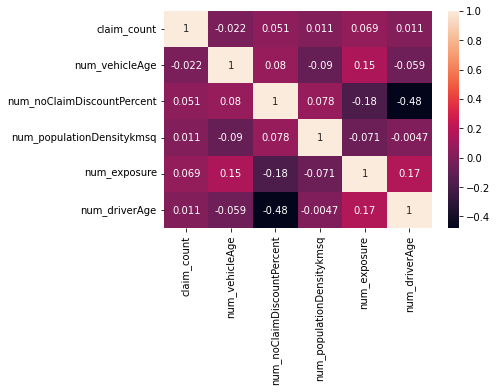

In [58]:
matrix = data.drop("claim").corr()
sb.heatmap(matrix, annot=True)
plt.show()

Looking at the correlation chart we see that the linear correlation is low so any relation to claim_count if it exist it must be non linear. So the model we train should try to catch those non-linearities.

Now we proceed to look at the distribution of the numerical variables divided between those that made a lcame and those that didn't.

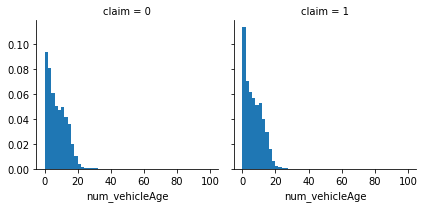

In [109]:
g = sb.FacetGrid(data, col='claim')
g.map(plt.hist, 'num_vehicleAge', bins=50, density=True)

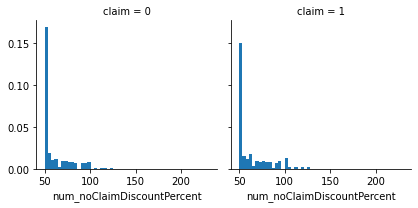

In [111]:
g = sb.FacetGrid(data, col='claim')
g.map(plt.hist, 'num_noClaimDiscountPercent', bins=50, density=True)

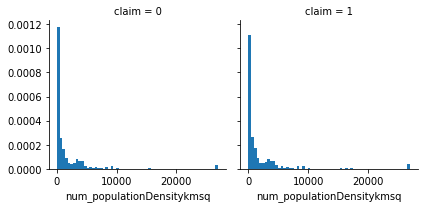

In [117]:
g = sb.FacetGrid(data, col='claim')
g.map(plt.hist, 'num_populationDensitykmsq', bins=60, density=True)

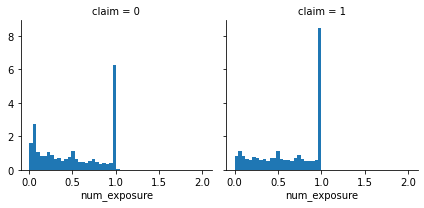

In [113]:
g = sb.FacetGrid(data, col='claim')
g.map(plt.hist, 'num_exposure', bins=50, density=True)

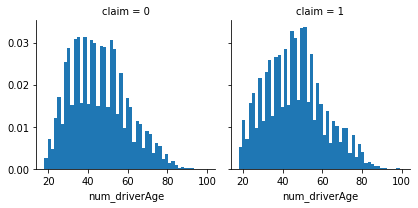

In [114]:
g = sb.FacetGrid(data, col='claim')
g.map(plt.hist, 'num_driverAge', bins=50, density=True)

Overall they look very similar the one that stood out the most was the drivers age

# ML Modeling

Now on to the model we start by sepparating the dataset into train and test, keeping the ratio of claimed cases the same in the two segments. We also need the column claim and claim_count as two sepparate columns to predict. 

In [324]:
y1=data['claim'].astype("category")

X_train, X_test, y1_train, y1_test = train_test_split(data.drop("claim",axis=1), y1, test_size=0.2, stratify=y1, random_state=42)

y2_train=X_train["claim_count"].loc[(data['claim_count']>0)]
y2_test=X_test["claim_count"].loc[(data['claim_count']>0)]

X2_train=X_train.drop("claim_count",axis=1).loc[(data['claim_count']>0)]
X2_test=X_test.drop("claim_count",axis=1).loc[(data['claim_count']>0)]

y_train=X_train["claim_count"]                                            
y_test=X_test["claim_count"] 
                                              
X_train=X_train.drop("claim_count",axis=1)
X_test=X_test.drop("claim_count",axis=1)
                                              
                                              

First we construct the encoders for each set of categorical values. While looking for the target encoder I found the GLMMEncoder that fits a linear model and uses the coefficients to encode the variables. The otehr encoder is a one hot encoder to turn each category into a column. 

In [184]:
onehotenc2 = ce.one_hot.OneHotEncoder(verbose=0, cols=["cat_fuelType","cat_areacode"], return_df=True, handle_missing='value', handle_unknown='value', use_cat_names=True)
binglmmenc2 = ce.glmm.GLMMEncoder(verbose=0, cols=["cat_carBrand","cat_Region","ord_vehicleHP"], return_df=True, handle_unknown='value', handle_missing='value', random_state=42, binomial_target=True)

Now that we have the encoders we are going to join them into a single pipeline

In [305]:
class InputProcessing(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        X = X.astype({'ord_vehicleHP': 'str'})
        X.loc[(X['ord_vehicleHP'].astype("int64") >16 ), 'ord_vehicleHP'] = 16
        X = X.astype({'ord_vehicleHP': 'category'})


        return X

In [306]:
class ModelRegTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X, **transform_params):
        return self.model.transform(X)
class ModelRegPred(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def predict(self, X, **transform_params):
        return self.model.predict(X)

In [307]:
data_pipeline = Pipeline([
        ('pre_pipeline', InputProcessing()),
        ('glmm_encoder', ModelRegTransformer(binglmmenc2)),
        ('dummy_encoder', ModelRegTransformer(onehotenc2)) ])

Now that we have the pipeline we can fit it so we can transform any incoming data

In [186]:
data_pipeline.fit(X_train,y1_train)

Pipeline(steps=[('pre_pipeline', InputProcessing()),
                ('glmm_encoder',
                 ModelRegTransformer(model=GLMMEncoder(binomial_target=True,
                                                       cols=['cat_carBrand',
                                                             'cat_Region',
                                                             'ord_vehicleHP'],
                                                       random_state=42))),
                ('dummy_encoder',
                 ModelRegTransformer(model=OneHotEncoder(cols=['cat_fuelType',
                                                               'cat_areacode'],
                                                         use_cat_names=True)))])

For the model I decided to use a gradient boosted trees model.
To take into account the imbalanced calsses I decided to add a class weight to improve the classification of the samples that have a claim. I will use 0.6 as the weight for no claims and 9 for claims (I could add this as another hyperparameter for tunning), this way the model will prioritize those samples with claims.
Would have used a bigger amount of estimators but ran out of time to make all the computations.


In [219]:
param_grid = {'max_depth': [5, 11],
              "learning_rate": [0.001, 0.1],
              "criterion": ["friedman_mse"],
              "min_impurity_decrease" : [0,0.1],
              "max_features" :["auto"],
              "subsample": [0.8],
              "n_estimators":[100],
              "validation_fraction":[0.2],
              "tol":[0.001],
              "n_iter_no_change":[10]             
             }
Xtn = data_pipeline.transform(X_train)
w=compute_sample_weight({0:.6,1:9},y1_train)
base_estimator = GradientBoostingClassifier(random_state=42)
sv = GridSearchCV(base_estimator, param_grid, cv=3, verbose=2).fit(Xtn, y1_train, sample_weight= w)




Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=5, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  53.2s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=5, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  52.6s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=5, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  52.7s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=5, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  52.6s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=5, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  53.4s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=5, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  53.4s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=11, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time= 2.2min


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=11, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time= 2.1min


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=11, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time= 2.1min


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=11, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time= 1.9min


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=11, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time= 1.9min


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.001, max_depth=11, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time= 1.9min


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  42.9s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  31.1s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  36.3s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  41.8s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  31.1s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  30.3s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=11, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  26.9s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=11, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  25.8s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=11, max_features=auto, min_impurity_decrease=0, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  27.1s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=11, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  24.3s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=11, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  24.6s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=11, max_features=auto, min_impurity_decrease=0.1, n_estimators=100, n_iter_no_change=10, subsample=0.8, tol=0.001, validation_fraction=0.2; total time=  24.7s


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [225]:
param_grid = {'max_depth': [5, 11],
              "learning_rate": [0.001, 0.1],
              "criterion": ["friedman_mse"],
              "max_features" :["auto"],
              "subsample": [0.8],
              "n_estimators":[100],
              "validation_fraction":[0.2],
              "tol":[0.001],
              "n_iter_no_change":[10]             
             }
Xtn2 = data_pipeline.transform(X2_train)
base_estimator2 = GradientBoostingRegressor(random_state=42)
sv2 = GridSearchCV(base_estimator2, param_grid, cv=3, verbose=2, n_jobs=-1).fit(Xtn2, y2_train)



Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Santiago desk\miniconda3\envs\py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [235]:
print(sv.best_score_)
print(sv2.best_score_)

0.9497662754384687
0.03264635558171588


In [262]:
print(sv.best_params_)

print(sv2.best_params_)


{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'max_depth': 5, 'max_features': 'auto', 'min_impurity_decrease': 0, 'n_estimators': 100, 'n_iter_no_change': 10, 'subsample': 0.8, 'tol': 0.001, 'validation_fraction': 0.2}
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 100, 'n_iter_no_change': 10, 'subsample': 0.8, 'tol': 0.001, 'validation_fraction': 0.2}


The results are not great but we will use those hyperparameters we found to train a bigger model.

In [292]:
bm=GradientBoostingClassifier(learning_rate= 0.001, max_depth= 5, subsample=0.8, n_estimators = 1500 ).fit(Xtn, y1_train, sample_weight= w)

Lets look at the models results:
- for training dataset:

In [313]:
y1_pred=bm.predict(Xtn)
confusion_matrix(y1_pred, y1_train)

array([[446510,  17606],
       [ 68553,   9636]], dtype=int64)

In [315]:
print(f"accuracy {metrics.accuracy_score(y1_pred, y1_train)}")
print(f"accuracy {metrics.precision_score(y1_pred, y1_train)}")
print(f"accuracy {metrics.recall_score(y1_pred, y1_train)}")

accuracy 0.8411244594831322
accuracy 0.35371852286909916
accuracy 0.12323984192149791


- for test dataset:

In [321]:
y1_predtest=bm.predict(data_pipeline.transform(X_test))
confusion_matrix(y1_predtest, y1_test)

array([[111488,   4411],
       [ 17279,   2399]], dtype=int64)

In [322]:
print(f"accuracy {metrics.accuracy_score(y1_predtest, y1_test)}")
print(f"accuracy {metrics.precision_score(y1_predtest, y1_test)}")
print(f"accuracy {metrics.recall_score(y1_predtest, y1_test)}")

accuracy 0.8400171120470287
accuracy 0.35227606461086636
accuracy 0.12191279601585527


Still not great but at least now we are getting some values to be predicted as claims. Also at least the model isn't overfitted so there's still space for improvement. 

In [273]:
bm2=GradientBoostingRegressor(max_depth=11, max_features='auto', random_state=42, subsample=0.8, n_estimators = 1500).fit(Xtn2, y2_train)

In [298]:
bm2.score(Xtn2,y2_train)

0.967673060494881

We now get a better better regression model.

The last thing we need now is to combine the two models so you first predict which samples are 0 and then pass the ones predicted to not be 0 to the second model.

In [299]:
class Combinar_modelos(BaseEstimator, TransformerMixin):
    def __init__(self, model1,model2):
        self.model1 = model1
        self.model2 = model2
    def fit(self, *args, **kwargs):
        return self
    def predict(self, X, **transform_params):
        X["clase"]=self.model1.predict(X)
        X["resultado"]=0
        print(X.loc[(X['clase']!=0)].drop(['clase',"resultado"],axis=1).shape)
        X.loc[(X['clase']!=0,"resultado")]=self.model2.predict(X.loc[(X['clase']!=0)].drop(['clase',"resultado"],axis=1))
        
        return X["resultado"].round()

Finally we join the model and data processing steps into a pipeline

In [308]:
modelo = Pipeline([
        ('datapipeline', data_pipeline),
        ('output', Combinar_modelos(bm,bm2))
    ])

In [316]:
ptest = modelo.predict(X_test)
ptrain = modelo.predict(X_train)
r2_test= [(mean_squared_error( ptest, y_test ))]
r2_train = [(mean_squared_error( ptrain, y_train ))]
resultados = pd.DataFrame.from_records([r2_train,r2_test])
resultados.index=['train','test']
resultados.columns=["mean_squared_error"]
resultados

(19678, 17)
(78189, 17)


,mean_squared_error
train,0.171120
test,0.174027


Now having tested the model we can save it to joblib and it can now be ready for deployment. The data that can be used with the model must be cleaned like we did in the first step to remove empty spaces and non numerical values in numeric columns (That cleanup step could also be integrated into the pipeline on a later time).  For it to work we to put all the classes I created into a python file. Then import that file wherever the model would be deployed for it to work.

In [309]:
joblib.dump(modelo,"predmodel.joblib")

['predmodel.joblib']

In the end wished I had a bit more time to improve the hyperparameter tunning so the model would have performed better in the end. But I'm satisfied with the work I've done up until now.
Thank you very much.